In [53]:
# Import
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [54]:
# Parameters
n = 50
C = 10
meanT = 9.3
meanM = 30
oneItemST = 3


# Factors

# FME_Exponential
p = [0.1,0.2,0.3]
K = [13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]


# CSV name
csv_name = "FME_Exponential_b"

In [ ]:

CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)

CSV = pd.concat([CSV[CSV["type"] == "scalar"], CSV[CSV["attrname"] == "iterationvarsd"]])

# CSV.to_csv(f"{csv_name}_cleaned.csv", index=False)

C:\Users\giova\AppData\Local\Temp\ipykernel_10600\131608406.py:1: DtypeWarning: Columns (2,3,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)


In [ ]:

# In the rows where attrname == "iterationvarsd", 
# attrvalue contains the current configuration
# in the following format: p/K
configurationInfo = CSV[CSV["attrname"] == "iterationvarsd"]


CSV_Scalar = CSV[CSV["type"] == "scalar"]

# S: Mean Service Time (t_S) [LocalSink] 
Exp_S = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.checkout.localSink")]
Exp_S = Exp_S[Exp_S["name"] == "totalServiceTime:mean"]

# TW: Total Mean Waiting Time [GlobalSink]
Exp_TW = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.globalSink")]
Exp_TW = Exp_TW[Exp_TW["name"] == "totalQueueingTime:mean"]

# W: Mean Waiting Time [Queues]
Exp_W = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.checkout.queues")]
Exp_W = Exp_W[Exp_W["name"] == "queueingTime:mean"]

# RHO: Mean Utilization [Queues]
Exp_RHO = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.checkout.queues")]
Exp_RHO = Exp_RHO[Exp_RHO["name"] == "busy:timeavg"]


# Dictionary for containing all the DataFrames
CSV_Dict = {
    "S": Exp_S,
    "W": Exp_W,
    "TW": Exp_TW,
    "RHO": Exp_RHO
}

# PI: Performance Indexes
PI = {}

# Configurations
config = {}

for _, row in configurationInfo.iterrows():
    # The key of config is the run number and the value is the configuration p_K
    config[row["run"].split("-")[2]] = row["attrvalue"].replace("/", "_")


for key in CSV_Dict:
    
    # --- Initialization Phase ---
    # The key of PI is the Performance Index and the value is a dictionary
    PI[key] = {}

    for c in config:
        # config[c] is the configuration p_K
        PI[key][config[c]] = {}

        for cc in config:
            # cc contains the run number
            PI[key][config[c]][cc] = {}
    # --- End of Initialization Phase ---

    for _, row in CSV_Dict[key].iterrows():
        # each row of CSV_Dict[key] is a run of the simulation with a specific configuration

        # In row we save the run number
        run = row["run"].split("-")[2]

        # Using a regex we search for all the occurencies of numbers inside row['module']
        q = re.findall(r'\d+', row["module"])

        if q:
            # If a number was found
            # e.g. SuperMarket.checkout.queues[0]
            # We take the first one (and only one)
            q = q[0]

            string = f"Q{q}"

            # For the current run we save the PI value of the queue "string" (e.g. Q0)
            PI[key][config[run]][run][string] = float(row["value"]) 
        else:
            # If none number was found
            # e.g. SuperMarket.globalSink

            # For the current run we save the PI value of the overall system
            PI[key][config[run]][run] = float(row["value"])

# PI_df: Performance Indexes DataFrame
PI_df = {}

# In Q we are going to save the names of the queues in the format Q0, Q1, ...
Q = []
for i in range(C):
    Q.append(f"Q{i}")


# --- Initialization Phase ---

for pi in PI:

    # The key of PI_df is the Performance Index and the value is a dictionary
    PI_df[pi] = {}

    for config in PI[pi]:

        if pi != "TW":
            # If pi is not TW we create a DataFrame with the columns Q (one column for each queue)
            PI_df[pi][config] = pd.DataFrame(columns=Q)

        else:
            # If pi is TW we create a DataFrame with just one column GS (Global Sink)
            PI_df[pi][config] = pd.DataFrame(columns=["GS"])

# --- End of Initialization Phase ---


for pi in PI:

    for config in PI[pi]:
    
        for run in PI[pi][config]:
            
            # Here we need to check if PI[pi][config][run] is different from {}
            # because if it is {} it means that the run was not related to 
            # that specific configuration
            if PI[pi][config][run]:

                # Check if PI[pi][config][run] is a dictionary
                if isinstance(PI[pi][config][run], dict):
                    # If it is a dictionary it means that
                    # it contains the PI values for each queue
                    for q in PI[pi][config][run]:
                        # We add the PI value of the queue q to the DataFrame
                        # at the row 'run' and at the column 'q'
                        PI_df[pi][config].loc[int(run), q] = PI[pi][config][run][q]
                else:
                    # If it is not a dictionary it means that
                    # it contains the PI value for the overall system

                    # We add the PI value of the overall system to the DataFrame
                    # at the row 'run'
                    PI_df[pi][config].loc[int(run)] = PI[pi][config][run]

        # We sort the DataFrame by the index (run number)
        PI_df[pi][config] = PI_df[pi][config].sort_index()
        # We reset the index of the DataFrame to start from 0
        PI_df[pi][config] = PI_df[pi][config].reset_index(drop=True)



In [ ]:
# E[W] = E[R]- E[t_S]

# E[R] = E[W] + E[t_S]
    
# We add a new Performance Index to PI_df
PI_df["R"] = {}

# For each configuration we compute the value of E[R] = E[W] + E[t_S]
for config in PI_df["W"]:
    # This is a sum of two DataFrames element-wise
    PI_df["R"][config] = PI_df["W"][config] + PI_df["S"][config]


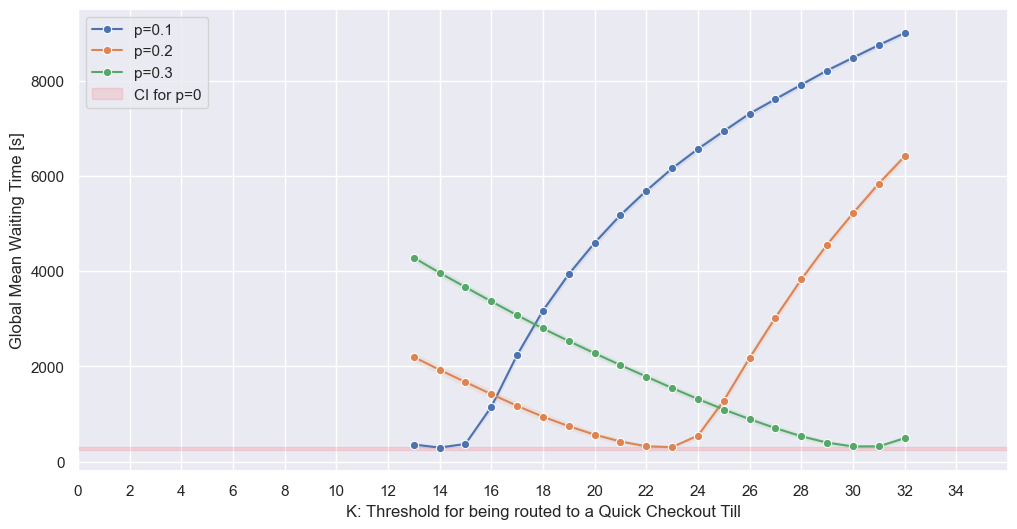

In [ ]:
# Total Waiting Time (Global Sink)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"


for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["GS"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["GS"].mean() - (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["GS"].mean() + (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
# plt.fill_between(y=[241.736, 305.333], alpha=0.1)
# plt.axhline(y=241.736, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=305.333, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([241.736, 305.333], 0, 36, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 36, 2))

# Set the x-axis limits
plt.xlim(0, 36)  
# Set the y-axis limits
# plt.ylim(250, 450)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of the overall system')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Global Mean Waiting Time [s]')

plt.legend()
plt.show()

In [ ]:


# for cc in configurations:
#     P_LOG[pi][cc] = pd.DataFrame(columns=Q)
#     for q in Q:
#         P_LOG[pi][cc][q] = np.log(PI_df[pi][cc][q].values.astype(np.float64).tolist())
# 
# P_LOG["W"]["0.1_14"]

In [ ]:
# Total Waiting Time (Global Sink)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"

temp_colors = ["b", "chocolate", "g"]
colors = {}
for p_ in p:
    colors[p_] = temp_colors.pop(0)

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci = []
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["GS"].mean())

        # We compute the confidence interval bounds
        ci.append(1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n)))
        ci_lb.append(PI_df[pi][couple]["GS"].mean() - (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["GS"].mean() + (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))
        # Cox Method
        ci_lb.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))
        ci_ub.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))


    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    plt.errorbar(x=K, y=y_W, fmt='o', yerr=ci, markersize=2, capsize=3, color=colors[p_])

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}", color=colors[p_], lw=1.5, alpha=0.5)


# Mean Value in the case of p = 0 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
# plt.fill_between(y=[241.736, 305.333], alpha=0.1)
# plt.axhline(y=241.736, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=305.333, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([241.736, 305.333], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(6, 38)  
# Set the y-axis limits
plt.ylim(220, 420)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of the overall system [Zoomed]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Total Mean Waiting Time [s]')

plt.legend()
plt.show()

NameError: name 'P_LOG' is not defined

<Figure size 1200x600 with 0 Axes>

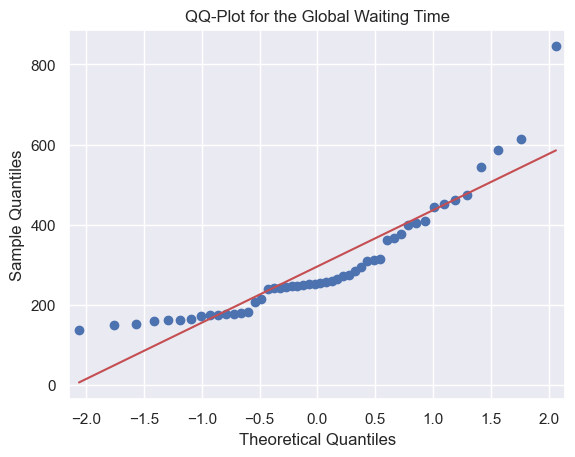

In [ ]:
from statsmodels.graphics.gofplots import qqplot

qqplot(PI_df["TW"]["0.1_14"]["GS"], line='s')
plt.title('QQ-Plot for the Global Waiting Time')
plt.show()

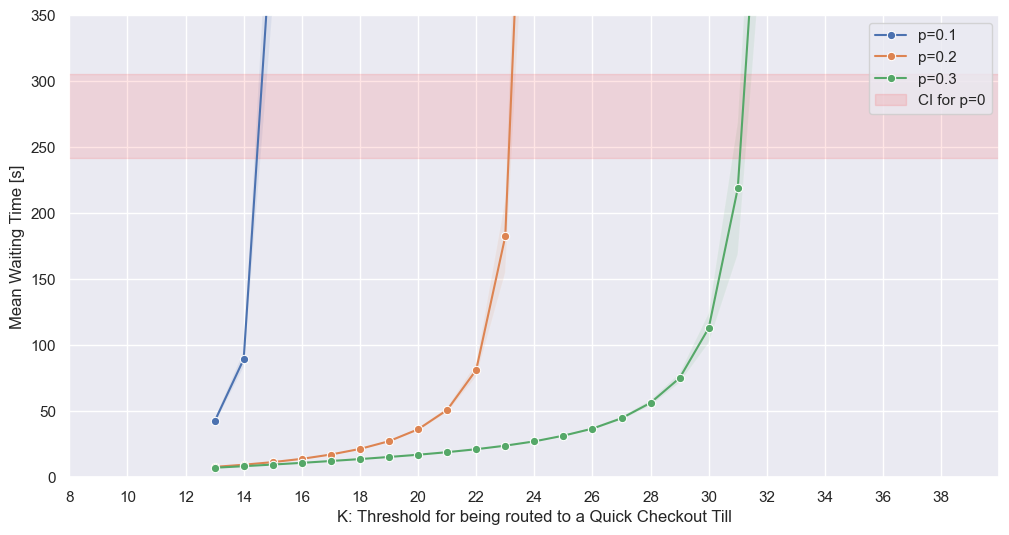

In [ ]:
# Mean Waiting Time for Q0
# Q0 is a quick checkout till in each configuration (p=0.1, p=0.2, p=0.3)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["Q0"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["Q0"].mean() - (1.96 * (PI_df[pi][couple]["Q0"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q0"].mean() + (1.96 * (PI_df[pi][couple]["Q0"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
# plt.fill_between(y=[241.736, 305.333], alpha=0.1)
# plt.axhline(y=241.736, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=305.333, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([241.736, 305.333], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(8, 40)  
# Set the y-axis limits
plt.ylim(0, 350)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of Q0 [Focus]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

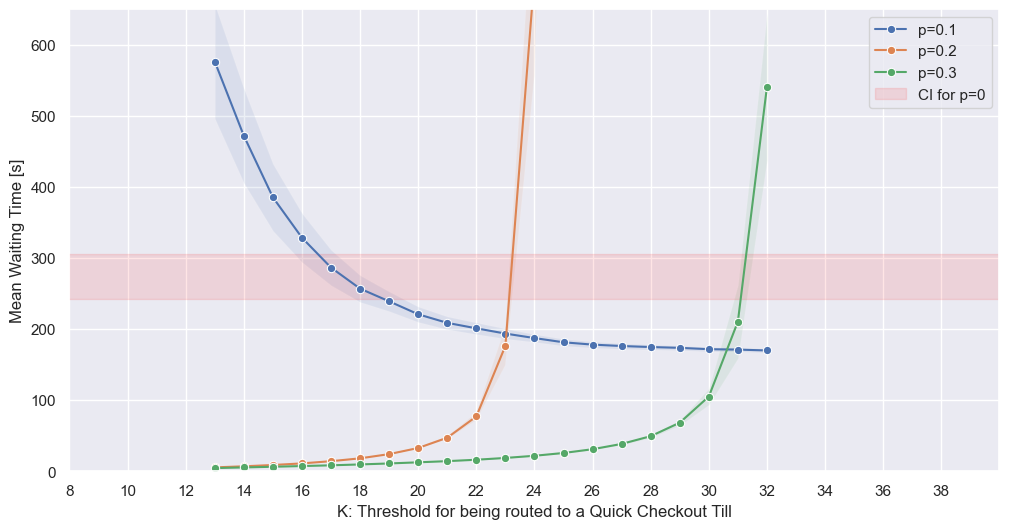

In [ ]:
# Mean Waiting Time for Q1
# Q1 is a normal checkout till for p=0.1
# Q1 is a quick checkout till for p=0.2
# Q1 is a quick checkout till for p=0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["Q1"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["Q1"].mean() - (1.96 * (PI_df[pi][couple]["Q1"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q1"].mean() + (1.96 * (PI_df[pi][couple]["Q1"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
# plt.fill_between(y=[241.736, 305.333], alpha=0.1)
# plt.axhline(y=241.736, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=305.333, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([241.736, 305.333], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(8, 40)  
# Set the y-axis limits
plt.ylim(0, 650)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of Q1 [Focus]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

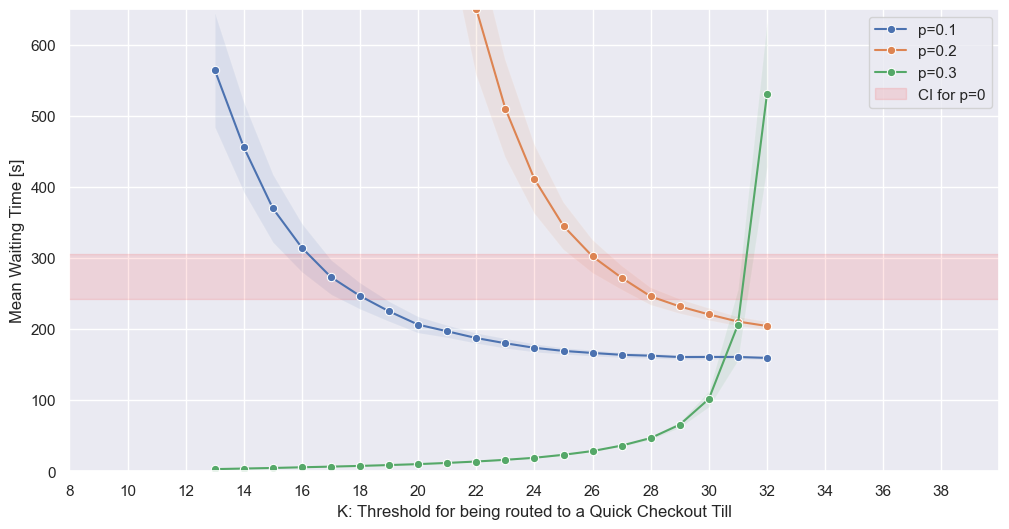

In [ ]:
# Mean Waiting Time for Q2
# Q2 is a normal checkout till for p=0.1
# Q2 is a normal checkout till for p=0.2
# Q2 is a quick checkout till for p=0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["Q2"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["Q2"].mean() - (1.96 * (PI_df[pi][couple]["Q2"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q2"].mean() + (1.96 * (PI_df[pi][couple]["Q2"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
# plt.fill_between(y=[241.736, 305.333], alpha=0.1)
# plt.axhline(y=241.736, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=305.333, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([241.736, 305.333], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(8, 40)  
# Set the y-axis limits
plt.ylim(0, 650)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of Q2 [Focus]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

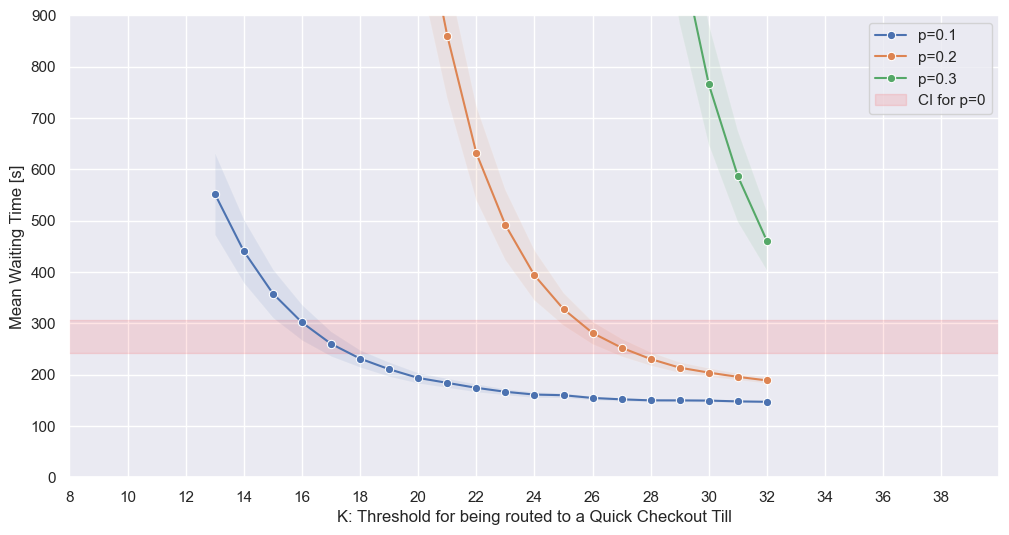

In [ ]:
# Mean Waiting Time for Q3
# Q3 is a normal checkout till for p=0.1
# Q3 is a normal checkout till for p=0.2
# Q3 is a normal checkout till for p=0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["Q3"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["Q3"].mean() - (1.96 * (PI_df[pi][couple]["Q3"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q3"].mean() + (1.96 * (PI_df[pi][couple]["Q3"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
# plt.fill_between(y=[241.736, 305.333], alpha=0.1)
# plt.axhline(y=241.736, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=305.333, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([241.736, 305.333], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(8, 40)  
# Set the y-axis limits
plt.ylim(0, 900)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of Q3 [Focus]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

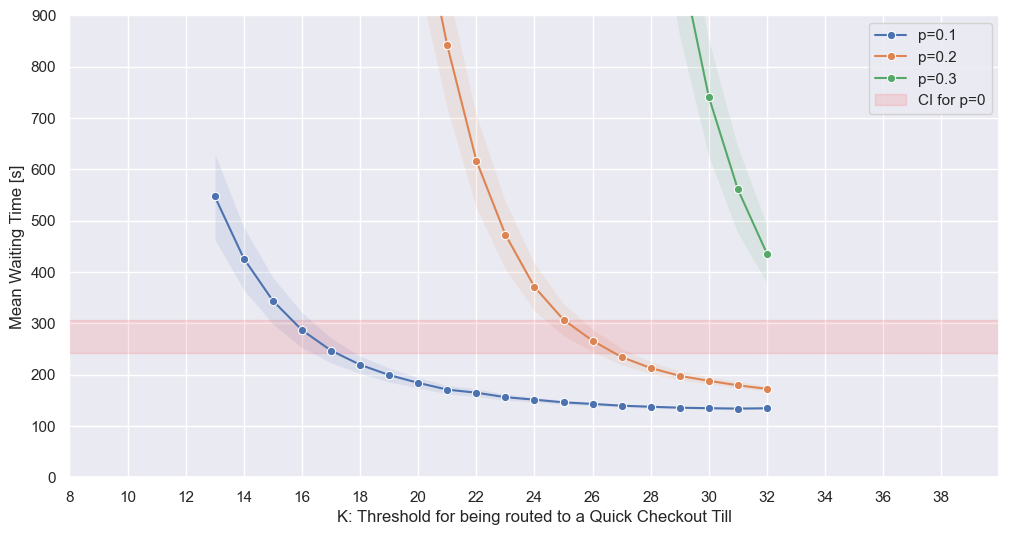

In [ ]:
# Mean Waiting Time for Q4
# Q4 is a normal checkout till for p=0.1
# Q4 is a normal checkout till for p=0.2
# Q4 is a normal checkout till for p=0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["Q4"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["Q4"].mean() - (1.96 * (PI_df[pi][couple]["Q4"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q4"].mean() + (1.96 * (PI_df[pi][couple]["Q4"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
# plt.fill_between(y=[241.736, 305.333], alpha=0.1)
# plt.axhline(y=241.736, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=305.333, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([241.736, 305.333], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(8, 40)  
# Set the y-axis limits
plt.ylim(0, 900)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of Q4 [Focus]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

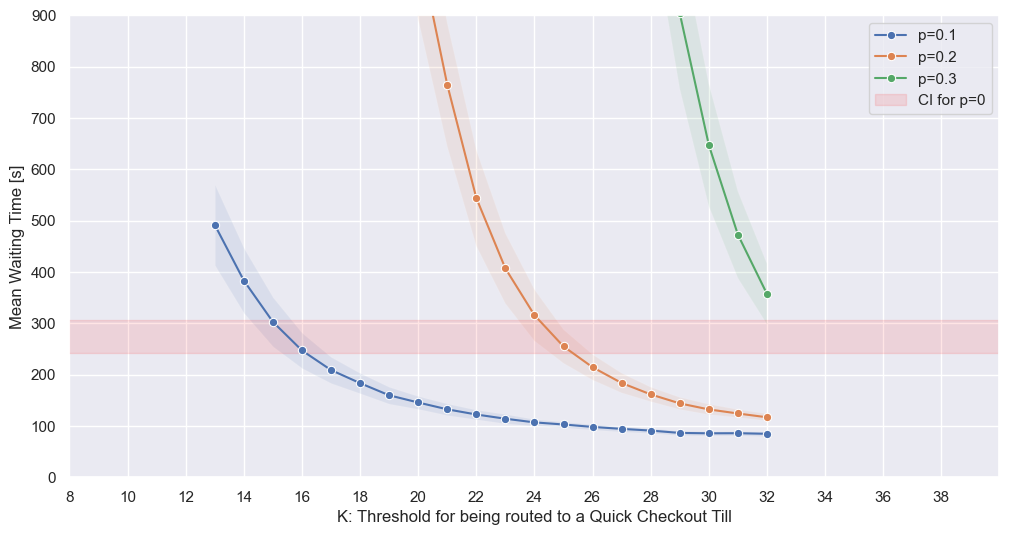

In [ ]:
# Mean Waiting Time for Q9
# Q9 is a normal checkout till for p=0.1
# Q9 is a normal checkout till for p=0.2
# Q9 is a normal checkout till for p=0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["Q9"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["Q9"].mean() - (1.96 * (PI_df[pi][couple]["Q9"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q9"].mean() + (1.96 * (PI_df[pi][couple]["Q9"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
# plt.fill_between(y=[241.736, 305.333], alpha=0.1)
# plt.axhline(y=241.736, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=305.333, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([241.736, 305.333], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(8, 40)  
# Set the y-axis limits
plt.ylim(0, 900)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of Q9 [Focus]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

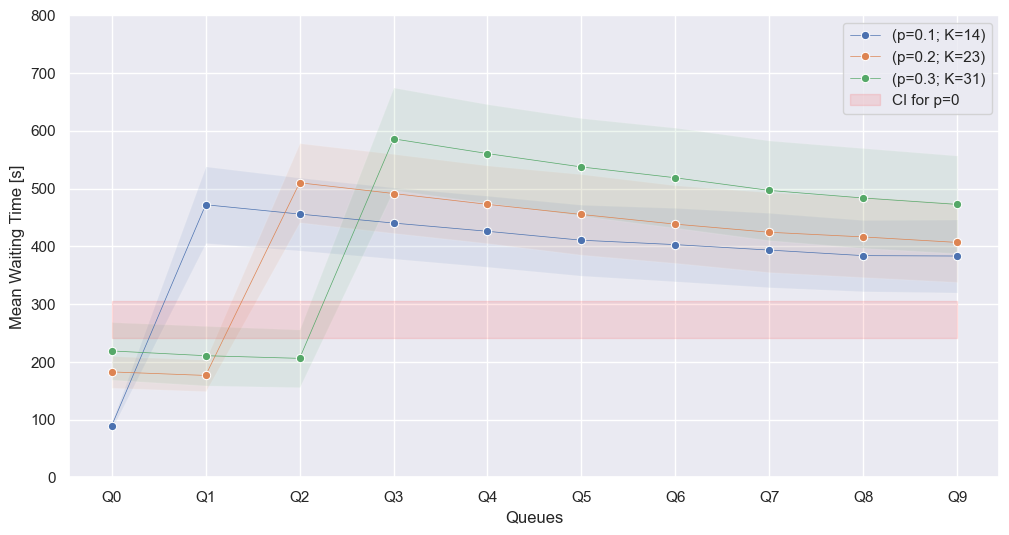

In [ ]:
# Plotting the Mean Waiting Time for each queue in the following configurations:
configurations = ["0.1_14", "0.2_23", "0.3_31"]

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for cc in configurations:

    # We save in y_W all the values for the current cc
    y_W = []

    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []

    for q in Q:

        y_W.append(PI_df[pi][cc][q].mean())

        ci_lb.append(PI_df[pi][cc][q].mean() - (1.96 * (PI_df[pi][cc][q].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][cc][q].mean() + (1.96 * (PI_df[pi][cc][q].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(Q, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current cc
    sns.lineplot(x=Q, y=y_W, marker='o', label=f"(p={cc.split('_')[0]}; K={cc.split('_')[1]})", lw=0.5)


# Mean Value in the case of p = 0 (and K=0) 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
plt.fill_betweenx([241.736, 305.333], 0, 9, color='red', alpha=0.1, label="CI for p=0")

# plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
# plt.xlim(0, 40)  
# Set the y-axis limits
plt.ylim(0, 800)  

# plt.title('Line Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

In [ ]:
configurations = ["0.1_14", "0.2_23", "0.3_31"]
pi = "W"
P_LOG = {}
P_LOG[pi] = {}

for cc in configurations:
    P_LOG[pi][cc] = pd.DataFrame(columns=Q)
    for q in Q:
        P_LOG[pi][cc][q] = np.log(PI_df[pi][cc][q].values.astype(np.float64).tolist())

# P_LOG["W"]["0.1_14"]

In [ ]:
P_LOG["W"]["0.1_14"]["Q1"].mean(), PI_df["W"]["0.1_14"]["Q1"].mean()

(6.054285686115087, 471.86704167042933)

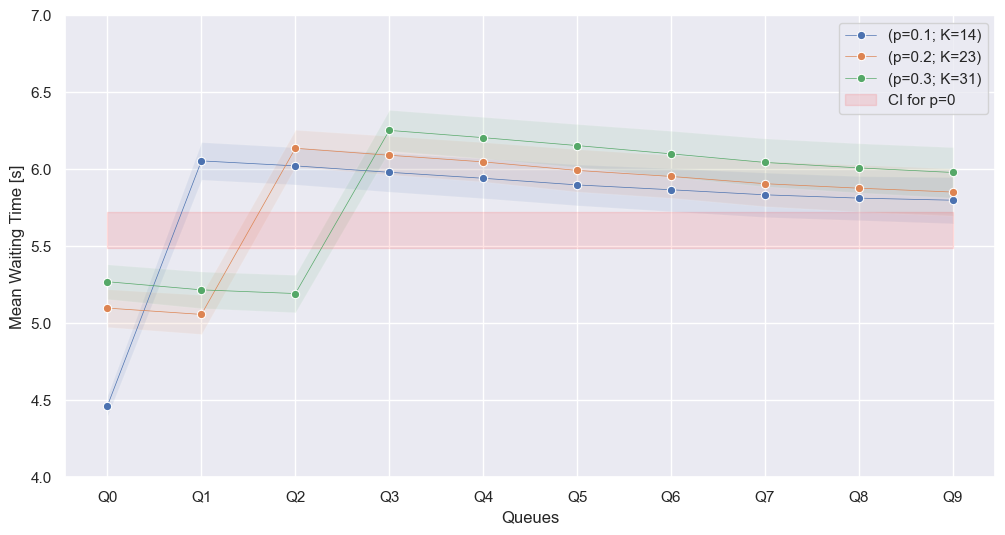

In [ ]:
# Plotting the Mean Waiting Time for each queue in the following configurations: LOGGG
configurations = ["0.1_14", "0.2_23", "0.3_31"]

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"


for cc in configurations:

    # We save in y_W all the values for the current cc
    y_W = []

    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []

    for q in Q:

        y_W.append(P_LOG[pi][cc][q].mean())

        ci_lb.append(P_LOG[pi][cc][q].mean() - (1.96 * (P_LOG[pi][cc][q].std() / math.sqrt(n))))
        ci_ub.append(P_LOG[pi][cc][q].mean() + (1.96 * (P_LOG[pi][cc][q].std() / math.sqrt(n))))
        # ci_lb.append(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1))))))
        # ci_ub.append(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1))))))


    # We plot the confidence intervals
    plt.fill_between(Q, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current cc
    sns.lineplot(x=Q, y=y_W, marker='o', label=f"(p={cc.split('_')[0]}; K={cc.split('_')[1]})", lw=0.5)


# Mean Value in the case of p = 0 (and K=0) 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
plt.fill_betweenx(np.log([241.736, 305.333]), 0, 9, color='red', alpha=0.1, label="CI for p=0")

# plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
# plt.xlim(0, 40)
# Set the y-axis limits
plt.ylim(4, 7)  

# plt.title('Line Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

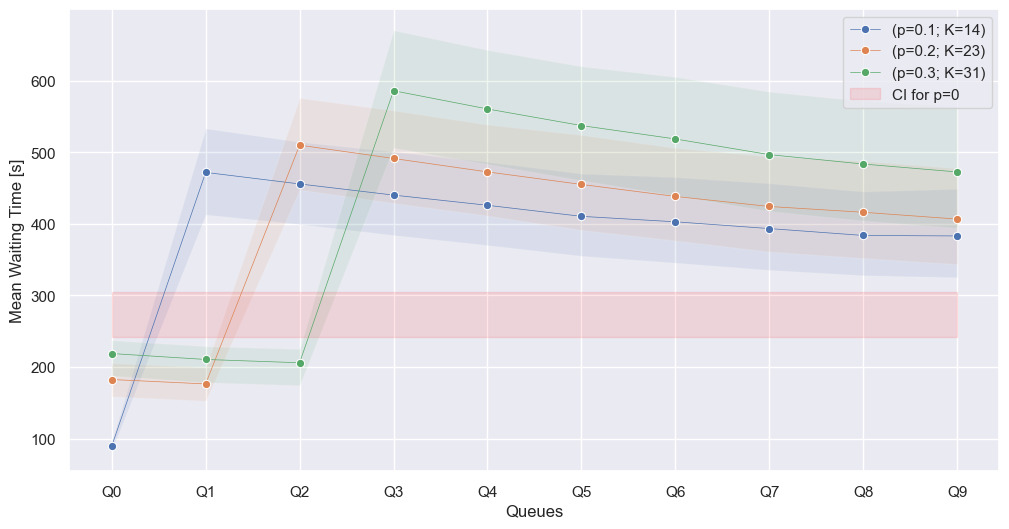

In [ ]:
# Plotting the Mean Waiting Time for each queue in the following configurations: LOGGG
configurations = ["0.1_14", "0.2_23", "0.3_31"]

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"


for cc in configurations:

    # We save in y_W all the values for the current cc
    y_W = []

    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []

    for q in Q:

        y_W.append(PI_df[pi][cc][q].mean())

        # ci_lb.append(np.exp(P_LOG[pi][cc][q].mean() - (1.96 * (P_LOG[pi][cc][q].std() / math.sqrt(n)))))
        # ci_ub.append(np.exp(P_LOG[pi][cc][q].mean() + (1.96 * (P_LOG[pi][cc][q].std() / math.sqrt(n)))))
        # mean + s^2/2 +_ 1.96 * sqrt(s^2/n + s^4/2(n-1))
        ci_lb.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))
        ci_ub.append(np.exp(P_LOG[pi][cc][q].mean() + (P_LOG[pi][cc][q].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][cc][q].std()**2 / n) + (P_LOG[pi][cc][q].std()**4 / (2 * (n-1)))))))


    # We plot the confidence intervals
    plt.fill_between(Q, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current cc
    sns.lineplot(x=Q, y=y_W, marker='o', label=f"(p={cc.split('_')[0]}; K={cc.split('_')[1]})", lw=0.5)


# Mean Value in the case of p = 0 (and K=0) 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
plt.fill_betweenx([241.736, 305.333], 0, 9, color='red', alpha=0.1, label="CI for p=0")

# plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
# plt.xlim(0, 40)
# Set the y-axis limits
# plt.ylim(4, 7)  

# plt.title('Line Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

In [ ]:
PI_df["W"]["0.1_14"]

,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9
0,70.782435,301.157465,283.095107,262.651366,233.371472,255.549205,219.545739,212.046739,215.062989,222.018681
1,86.110165,438.735353,440.059502,388.596038,426.949921,368.62691,365.264023,350.318892,356.389314,331.404162
2,57.484306,219.866413,222.651236,219.434985,187.345714,177.69551,175.179287,161.245606,170.515337,135.056857
3,93.98672,511.45877,480.475156,454.127589,440.973873,440.433624,407.723693,418.990032,405.582735,407.038069
4,93.229726,638.784685,643.155212,639.786685,545.869112,563.749586,564.678168,584.830166,556.674799,550.616965
5,145.951527,369.826879,329.873842,323.822066,354.952534,305.213396,284.574119,293.834085,271.397593,275.906022
6,108.174166,413.691254,434.482822,384.329986,376.540452,353.707309,356.112012,364.884304,313.975683,312.238317
7,82.75933,282.837596,289.083551,257.622704,235.637368,237.784152,230.659252,198.804053,205.59031,213.007608
8,107.916124,546.433588,580.891052,579.564942,580.52451,529.119273,509.154153,511.450379,508.401283,533.696805
9,89.507191,419.443962,395.609723,425.063142,383.392087,341.608865,334.215383,312.112513,316.443105,302.840588


C:\Users\giova\AppData\Local\Temp\ipykernel_10600\3428650683.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(PI_df["W"]["0.1_14"]["Q1"], hist=False, rug=True, label="Q1")


<Axes: xlabel='Q1', ylabel='Density'>

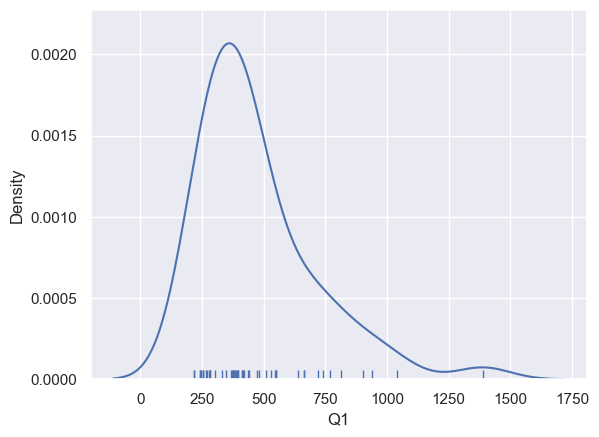

In [ ]:
# Plot the epdf of PI_df["W"]["0.1_14"]["Q1"]
sns.distplot(PI_df["W"]["0.1_14"]["Q1"], hist=False, rug=True, label="Q1")


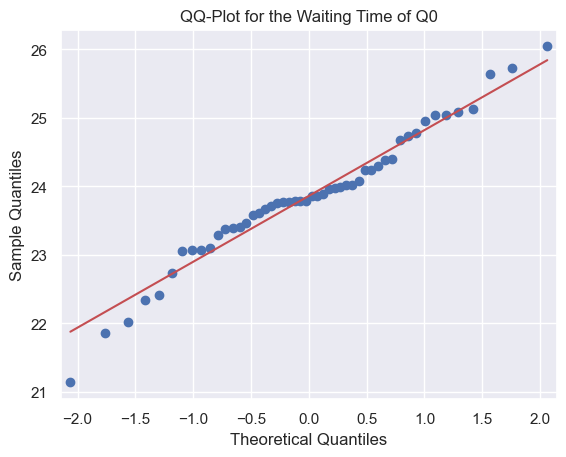

[5.64578291 6.08690995 5.40560658 6.17477552 6.46638608 5.79871028
 6.07415641 5.66671575 6.36456322 5.98042818 5.80724994 5.52400056
 6.01206807 6.86921233 6.48056036 7.20036615 5.57919925 6.43184458
 5.58499817 5.60500783 5.45768787 6.39563594 5.42946829 6.81972527
 6.01752923 5.57281726 6.12711264 6.73211737 6.26906574 6.59448625
 5.99386368 5.8844417  6.00404983 5.37533805 5.53383355 6.62914281
 6.06388677 5.86094365 5.88780099 5.83245166 5.97356503 5.74057695
 6.58262124 6.10884181 5.58623419 5.41459473 5.8802839  6.52171784
 5.93621041 6.11047654]


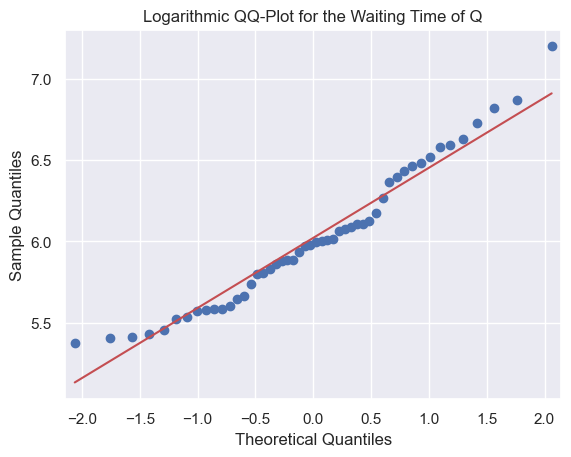

In [ ]:
from statsmodels.graphics.gofplots import qqplot
import numpy as np
# Plot QQ-Plot for the Waiting Time of Q0
import matplotlib.pyplot as plt

qqplot(PI_df["W"]["0.3_23"]["Q0"], line='s')
plt.title('QQ-Plot for the Waiting Time of Q0')
plt.show()

# Take the logarithm of the data
prova = PI_df["W"]["0.1_14"]["Q2"].values
log_data = np.log(prova.astype(np.float64))
print(log_data)

qqplot(log_data, line='s')
plt.title('Logarithmic QQ-Plot for the Waiting Time of Q')
plt.show()



In [ ]:
PI_df["W"]["0.1_14"]["Q1"].std()**2

57394.63761024707

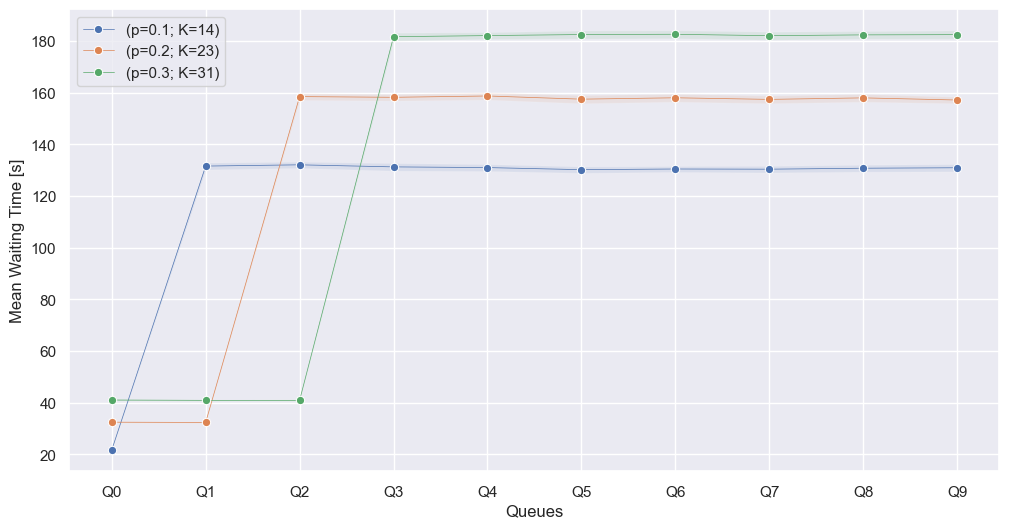

In [ ]:
# Plotting the Mean Waiting Time for each queue in the following configurations:
configurations = ["0.1_14", "0.2_23", "0.3_31"]

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "S"

for cc in configurations:

    # We save in y_W all the values for the current cc
    y_W = []

    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []

    for q in Q:

        y_W.append(PI_df[pi][cc][q].mean())

        ci_lb.append(PI_df[pi][cc][q].mean() - (1.96 * (PI_df[pi][cc][q].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][cc][q].mean() + (1.96 * (PI_df[pi][cc][q].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(Q, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current cc
    sns.lineplot(x=Q, y=y_W, marker='o', label=f"(p={cc.split('_')[0]}; K={cc.split('_')[1]})", lw=0.5)


# Mean Value in the case of p = 0 (and K=0) 273.535
# Confidence Interval Bounds: LB: 241.736  UB: 305.333
# plt.fill_betweenx([241.736, 305.333], 0, 9, color='red', alpha=0.1, label="CI for p=0")

# plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
# plt.xlim(0, 40)  
# Set the y-axis limits
# plt.ylim(0, 1000)  

# plt.title('Line Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()